In [49]:

import seaborn as sn
import fnmatch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
import numpy as np
import torchvision
from  numpy import exp,absolute
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier as mlp
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
from torchmetrics.functional.classification import multiclass_confusion_matrix as mcm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score,f1_score,precision_score ,recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


In [33]:
#hyper params
lr = 1e-4
wd = 1e-3
feature_extract = True
#lr = 1e-4
bs = 64
val_split = 0.85
test_split = 0.90
num_epoch = 20
classes = [5,6,7,8,9,10,11,12,14,16]
num_classes = len(classes)
path = './relevant_dataset'

In [19]:

def get_dataset(path,val_split,test_split):
    data_transforms = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=10),
        transforms.RandomCrop(size=256),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(path,transform=data_transforms)
    
    top_size = math.floor(len(dataset)*test_split)
    train_size = math.floor(len(dataset)*val_split)
    val_size = top_size - train_size
    test_size = len(dataset) - top_size
    topset,testset = data.random_split(dataset,lengths=[top_size,test_size])
    trainset,valset = data.random_split(topset,lengths=[train_size,val_size])
    
    print(len(trainset),len(valset),len(testset))
    
    return trainset,valset,testset

In [20]:
def train_model(trainset, valset, model, criterion, optimizer, scheduler, num_epochs,bs,hardness_threshold):
    dataloaders = {
        'train': data.DataLoader(trainset,batch_size=bs,shuffle=True),
        'val' : data.DataLoader(valset,batch_size=bs,shuffle=True)
    }
    dataset_sizes = {'train':len(trainset),'val':len(valset)}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # List to store entropy values for each epoch
    entropy_values_train = []  
    entropy_values_val = []  
    #List to store loss of each epoch
    E_loss_train = []         
    E_loss_val = []
    # List to store balanced accuracy for training phase
    balanced_acc_train = []  
    balanced_acc_val = []    

          
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        c = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            epoch_entropy = 0.0  # Variable to store epoch entropy


            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                #labels = torch.tensor(labels)
                labels = labels.to(device)
                #print(labels)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) 

                    loss = criterion(outputs, labels)
                    
                    balanced_acc = balanced_accuracy_score(labels.cpu(), preds.cpu())  # Calculate balanced accuracy
                    
                    
                    # Calculate hardness score for each sample in the batch
                    probabilities_hard = torch.softmax(outputs, dim=1)
                    hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]
                    #print('hardness score',hardness_scores)
                    
                    # Skip predictions if hardness score is greater than the threshold
                    skip_mask = hardness_scores <= hardness_threshold
                    if skip_mask.sum().item() > 0:
                        c+=1
                        inputs = inputs[skip_mask]
                        labels = labels[skip_mask]
                        preds = preds[skip_mask]
                        loss = criterion(outputs[skip_mask], labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Calculate entropy for each batch and accumulate for epoch entropy
                probabilities = torch.softmax(outputs, dim=1)
                entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), dim=1)
                epoch_entropy += torch.sum(entropy)

            #confusion_matrix(preds, labels)

            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_entropy /= dataset_sizes[phase]  # Calculate average epoch entropy
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Epoch Entropy: {:.4f}'.format(phase,epoch_entropy.item()))
            print('{} Balanced Accuracy: {:.4f}'.format(phase,balanced_acc))
            print()
            
            if phase == 'train':
                # Save epoch entropy to the list
                entropy_values_train.append(epoch_entropy.item())
                #save epoch loss in a list
                E_loss_train.append(epoch_loss)
                #save epoch balanced loss in a list
                balanced_acc_train.append(balanced_acc)  # Append balanced accuracy for training

            else:
                # Save epoch entropy to the list
                entropy_values_val.append(epoch_entropy.item())
                #save epoch loss in a list
                E_loss_val.append(epoch_loss)
                #save epoch balanced loss in a list
                balanced_acc_val.append(balanced_acc)  # Append balanced accuracy for validation


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            # Apply weight decay to the parameters after each epoch
            for param in model.parameters():
                param.data -= lr * param.grad.data + wd * param.data
                
        print('Number of skipped:',c)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
   
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val

In [21]:
def test_model(model, testset):
    running_corrects = 0
    testloader = data.DataLoader(testset,batch_size=bs,shuffle=True)
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
    return (running_corrects/len(testset))


In [22]:

def weighted_score_array(models,dataset):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader = data.DataLoader(dataset,batch_size=64,shuffle=True)
    for inputs,labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        predictions = set()
        with torch.set_grad_enabled(False):
            x = models[0](inputs)
            _, preds = torch.max(x, 1)
            predictions.add(preds)
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                x = torch.cat((x,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,x.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,x.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [23]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [24]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 256

    if model_name == "resnet":
        """ Resnet50
        """
        print("Resnet50")
        model_ft = models.resnet50(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Linear(2048,num_classes)
        #num_ftrs = model_ft.fc.in_features
        #model_ft.fc = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "mobilenet":
        """ Mobilenet_V2
        """
        print("Mobilenet_V2")
        model_ft = torchvision.models.mobilenet_v2(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
            )
            #nu        #num_features = model.classifier[1].in_features
        #model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vgg":
        """ VGG16_bn
        """
        print("VGG16_bn")
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[6] = nn.Linear(4096, num_classes)
        #num_ftrs = model_ft.classifier[6].in_features
        #model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "googlenet":
        """ googlenet
        """
        print("VGG16_bn")
        model_ft = torchvision.models.googlenet(weights='DEFAULT')
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Linear(1024,num_classes)
        #model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        #model_ft.num_classes = num_classes

    elif model_name == "densenet":
        """ Densenet
        """
        print("Densenet")
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier = nn.Linear(2208,num_classes)
        #num_ftrs = model_ft.classifier.in_features
        #model_ft.classifier = nn.Linear(num_ftrs, num_classes)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run

# Print the model we just instantiated
#print(model_ft)


In [25]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
def plot_distribution_by_class(dataset, classes):
    dataloaders = data.DataLoader(dataset,batch_size=bs,shuffle=True)
    count = [0] * len(classes)  # Initialize count list with zeros

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        
    
        for i in labels:
            count[i] += 1
    
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.bar(x, count)
    plt.xticks(x, classes)  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.show()

In [34]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Separate the train, val, and test sets
trainset, valset, testset = get_dataset(path, val_split, test_split)

13167 774 1550


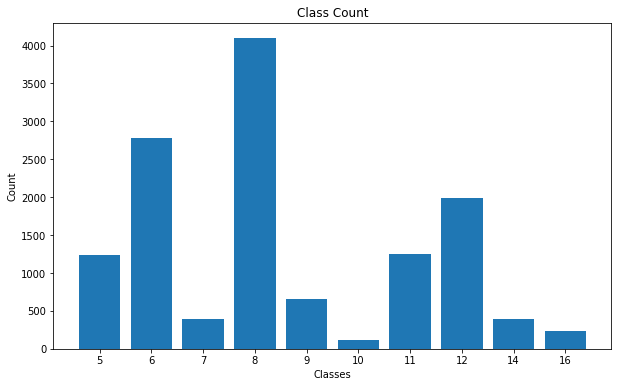

In [35]:
plot_distribution_by_class(trainset, classes)

In [36]:


model_list = []
hardness_threshold = 0.75
for model_name in ["resnet"]:
    
    # Initialize the model
    model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    
    model_list.append(model)
    
    # Send model to GPU, if available
    model = model.to(device)
    
    params_to_update = model.parameters()
    
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print("\t", name)
    
    # Observe that all parameters are being optimized
    optimizer = optim.Adam(params_to_update, lr=lr, weight_decay=wd)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val = train_model(trainset, valset, model, criterion, optimizer, exp_lr_scheduler, num_epoch, bs,hardness_threshold)
    
    print(test_model(model, testset))





Resnet50


/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 1.4696 Acc: 0.4184
train Epoch Entropy: 2.3472
train Balanced Accuracy: 0.2807



/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.4562 Acc: 0.5026
val Epoch Entropy: 2.0493
val Balanced Accuracy: 0.6667

Number of skipped: 216

Epoch 1/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 1.4276 Acc: 0.4785
train Epoch Entropy: 2.0956
train Balanced Accuracy: 0.2989



/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.3583 Acc: 0.4935
val Epoch Entropy: 2.0508
val Balanced Accuracy: 0.1667

Number of skipped: 219

Epoch 2/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 1.3865 Acc: 0.4924
train Epoch Entropy: 2.0349
train Balanced Accuracy: 0.3254



/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.3512 Acc: 0.4961
val Epoch Entropy: 1.9632
val Balanced Accuracy: 0.1250

Number of skipped: 219

Epoch 3/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 1.3551 Acc: 0.5051
train Epoch Entropy: 2.0018
train Balanced Accuracy: 0.2628



/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.3372 Acc: 0.5116
val Epoch Entropy: 2.0127
val Balanced Accuracy: 0.3000

Number of skipped: 219

Epoch 4/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 1.3314 Acc: 0.5122
train Epoch Entropy: 1.9600
train Balanced Accuracy: 0.4520



/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.3682 Acc: 0.5078
val Epoch Entropy: 1.9144
val Balanced Accuracy: 0.5000

Number of skipped: 219

Epoch 5/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 1.3002 Acc: 0.5186
train Epoch Entropy: 1.9370
train Balanced Accuracy: 0.2253



/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.3849 Acc: 0.5078
val Epoch Entropy: 1.8817
val Balanced Accuracy: 1.0000

Number of skipped: 219

Epoch 6/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 1.2753 Acc: 0.5267
train Epoch Entropy: 1.8953
train Balanced Accuracy: 0.3478

val Loss: 1.4127 Acc: 0.5026
val Epoch Entropy: 1.8937
val Balanced Accuracy: 0.7500

Number of skipped: 219

Epoch 7/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 1.1424 Acc: 0.5761
train Epoch Entropy: 1.8864
train Balanced Accuracy: 0.4153



/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.3601 Acc: 0.5336
val Epoch Entropy: 1.7936
val Balanced Accuracy: 0.4000

Number of skipped: 219

Epoch 8/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 1.0761 Acc: 0.6107
train Epoch Entropy: 1.7905
train Balanced Accuracy: 0.4010



/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.3670 Acc: 0.5181
val Epoch Entropy: 1.7831
val Balanced Accuracy: 0.7500

Number of skipped: 219

Epoch 9/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 1.0079 Acc: 0.6329
train Epoch Entropy: 1.7405
train Balanced Accuracy: 0.3975

val Loss: 1.4438 Acc: 0.5116
val Epoch Entropy: 1.6749
val Balanced Accuracy: 0.3333

Number of skipped: 219

Epoch 10/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.9534 Acc: 0.6575
train Epoch Entropy: 1.6791
train Balanced Accuracy: 0.4244



/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.4429 Acc: 0.5168
val Epoch Entropy: 1.6653
val Balanced Accuracy: 0.3333

Number of skipped: 219

Epoch 11/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.8901 Acc: 0.6820
train Epoch Entropy: 1.6006
train Balanced Accuracy: 0.5516



/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.5016 Acc: 0.5013
val Epoch Entropy: 1.6300
val Balanced Accuracy: 0.2500

Number of skipped: 219

Epoch 12/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.8274 Acc: 0.7090
train Epoch Entropy: 1.5405
train Balanced Accuracy: 0.4298



/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.5140 Acc: 0.4703
val Epoch Entropy: 1.6257
val Balanced Accuracy: 0.5000

Number of skipped: 219

Epoch 13/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.7649 Acc: 0.7317
train Epoch Entropy: 1.4679
train Balanced Accuracy: 0.6272



/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.5595 Acc: 0.4935
val Epoch Entropy: 1.5628
val Balanced Accuracy: 0.3333

Number of skipped: 219

Epoch 14/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.6847 Acc: 0.7709
train Epoch Entropy: 1.4197
train Balanced Accuracy: 0.6443



/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.6113 Acc: 0.4884
val Epoch Entropy: 1.5167
val Balanced Accuracy: 0.5000

Number of skipped: 219

Epoch 15/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.6780 Acc: 0.7779
train Epoch Entropy: 1.4119
train Balanced Accuracy: 0.6044

val Loss: 1.5437 Acc: 0.4935
val Epoch Entropy: 1.5456
val Balanced Accuracy: 0.5000

Number of skipped: 219

Epoch 16/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.6608 Acc: 0.7791
train Epoch Entropy: 1.3986
train Balanced Accuracy: 0.5938



/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.5817 Acc: 0.4922
val Epoch Entropy: 1.5511
val Balanced Accuracy: 0.5000

Number of skipped: 219

Epoch 17/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.6496 Acc: 0.7870
train Epoch Entropy: 1.3961
train Balanced Accuracy: 0.6883



/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.5803 Acc: 0.4897
val Epoch Entropy: 1.5379
val Balanced Accuracy: 0.2500

Number of skipped: 219

Epoch 18/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.6470 Acc: 0.7867
train Epoch Entropy: 1.3879
train Balanced Accuracy: 0.6005



/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.5759 Acc: 0.4806
val Epoch Entropy: 1.5378
val Balanced Accuracy: 0.6250

Number of skipped: 219

Epoch 19/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.6407 Acc: 0.7882
train Epoch Entropy: 1.3779
train Balanced Accuracy: 0.8065



/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.5948 Acc: 0.4755
val Epoch Entropy: 1.5502
val Balanced Accuracy: 0.5833

Number of skipped: 219

Training complete in 34m 41s
Best val Acc: 0.533592
tensor(0.4987, device='cuda:0')


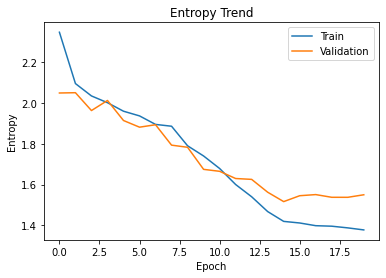

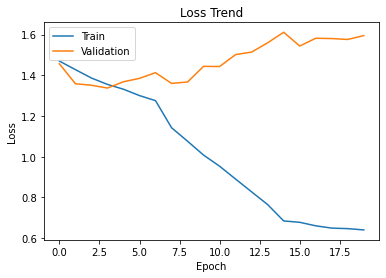

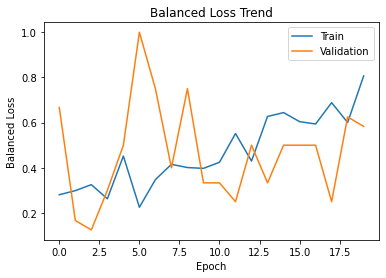

In [37]:

import matplotlib.pyplot as plt

# Plot entropy values
plt.figure()
plt.plot(entropy_values_train, label='Train')
plt.plot(entropy_values_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy Trend')
plt.legend()
plt.show()

# Plot loss values
plt.figure()
plt.plot(E_loss_train, label='Train')
plt.plot(E_loss_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

# Plot balanced loss values
plt.figure()
plt.plot(balanced_acc_train, label='Train')
plt.plot(balanced_acc_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Balanced Loss')
plt.title('Balanced Loss Trend')
plt.legend()
plt.show()


In [39]:
    
train_X, train_Y = weighted_score_array(model_list, trainset)
test_X, test_Y = weighted_score_array(model_list, testset)

#make a dummy prediction, i.e Random Baseline
# Create a dummy classifier with a strategy
dummy_clf = DummyClassifier(strategy='uniform')

# Train the dummy classifier
dummy_clf.fit(train_X, train_Y)

# Make predictions on the test set
predictions = dummy_clf.predict(test_X)

# Evaluate the accuracy of the dummy classifier
accuracy = dummy_clf.score(test_X, test_Y)

print("Dummy Classifier Accuracy/ Random Baseline:", accuracy)

Dummy Classifier Accuracy/ Random Baseline: 0.09806451612903226


Accuracy for SVM: 0.4806451612903226
Balanced Accuracy:0.2759092479770676


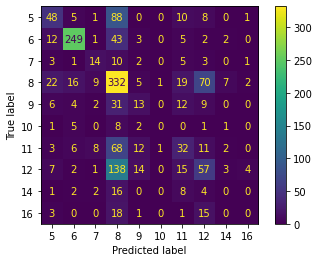

<Figure size 576x432 with 0 Axes>

In [53]:
    
# Predict using SVM
model_svc = SVC(decision_function_shape='ovr', C=500, kernel='rbf')
model_svc.fit(train_X, train_Y)
pred = model_svc.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for SVM: ' + str(acc))
balanced_svm = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_svm))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

/home/rishav/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy for MLP: 0.4619354838709677
Balanced Accuracy:0.2690255186858337


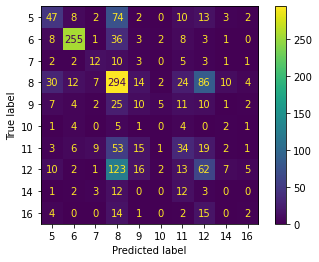

<Figure size 576x432 with 0 Axes>

In [54]:
# Predict using MLP
model_mlp = mlp(solver='lbfgs', alpha=1e-5, random_state=5, max_iter=100000)
model_mlp.fit(train_X, train_Y)
pred = model_mlp.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for MLP: ' + str(acc))
balanced_mlp = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_mlp))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()